## x-means法によるクラスタリング

In [41]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn import cluster, preprocessing
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import matplotlib.pyplot as plt
import japanize_matplotlib
import geopandas as gpd
pd.set_option('display.max_columns', 200)

In [2]:
# データ読込先・出力先パス
data_path = '../output/data_preprocessed/e-stat/'
file_path = 'estat_population_2020_preprocessed_total.xlsx'
output_path = '../output/clustering_results/xmeans/'
shapefile_path = '../output/data_preprocessed/e-stat/shapefile/'

In [3]:
# データの読み込み
df = pd.read_excel(data_path + file_path)
df

,男女,市区町村コード,町丁字コード,都道府県名,市区町村名,大字・町名,字・丁目名,住所,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
0,総数,26203,3009,京都府,綾部市,口上林,十倉中町,京都府綾部市口上林十倉中町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,総数,26203,7207,京都府,綾部市,吉美,工業団地,京都府綾部市吉美工業団地,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,総数,26203,8060,京都府,綾部市,綾部,味方町,京都府綾部市綾部味方町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,総数,26203,8063,京都府,綾部市,綾部,青野町,京都府綾部市綾部青野町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,総数,26203,8030,京都府,綾部市,綾部,青野町,京都府綾部市綾部青野町,1777,124,95,80,76,82,111,118,135,111,158,130,117,85,85,87,58,51,21,21,3,0,29,299,1123,326,154,45,1132,0.069781,0.053461,0.04502,0.042769,0.046145,0.062465,0.066404,0.075971,0.062465,0.088914,0.073157,0.065841,0.047833,0.047833,0.048959,0.032639,0.0287,0.011818,0.011818,0.001688,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36191,総数,25211,305,滋賀県,湖南市,石部,NaN,滋賀県湖南市石部,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36192,総数,25211,270,滋賀県,湖南市,西峰町,NaN,滋賀県湖南市西峰町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36193,総数,25211,220,滋賀県,湖南市,小砂町,NaN,滋賀県湖南市小砂町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36194,総数,25211,250,滋賀県,湖南市,高松町,NaN,滋賀県湖南市高松町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.copy()
for col in df.loc[:, '総数':'20～69'].columns:
    df[col] = df[col].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36196 entries, 0 to 36195
Data columns (total 58 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   男女          36196 non-null  object 
 1   市区町村コード     36196 non-null  int64  
 2   町丁字コード      36196 non-null  object 
 3   都道府県名       36196 non-null  object 
 4   市区町村名       36196 non-null  object 
 5   大字・町名       36167 non-null  object 
 6   字・丁目名       22945 non-null  object 
 7   住所          36196 non-null  object 
 8   総数          36196 non-null  int32  
 9   0～4         36196 non-null  int32  
 10  5～9         36196 non-null  int32  
 11  10～14       36196 non-null  int32  
 12  15～19       36196 non-null  int32  
 13  20～24       36196 non-null  int32  
 14  25～29       36196 non-null  int32  
 15  30～34       36196 non-null  int32  
 16  35～39       36196 non-null  int32  
 17  40～44       36196 non-null  int32  
 18  45～49       36196 non-null  int32  
 19  50～54       36196 non-nul

In [5]:
# 必要データだけに絞り込み
df_pre = df.drop(df.columns[0:7], axis = 1)
df_in_use = df_pre.loc[:, '住所':'人口比率_100～']
# 欠損値は0で置換（分母（＝総数）が0で計算できていないエリア）
df_in_use = df_in_use.fillna(0)
df_in_use

,住所,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
0,京都府綾部市口上林十倉中町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
1,京都府綾部市吉美工業団地,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
2,京都府綾部市綾部味方町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
3,京都府綾部市綾部青野町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
4,京都府綾部市綾部青野町,1777,124,95,80,76,82,111,118,135,111,158,130,117,85,85,87,58,51,21,21,3,0,29,299,1123,326,154,45,1132,0.069781,0.053461,0.04502,0.042769,0.046145,0.062465,0.066404,0.075971,0.062465,0.088914,0.073157,0.065841,0.047833,0.047833,0.048959,0.032639,0.0287,0.011818,0.011818,0.001688,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36191,滋賀県湖南市石部,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
36192,滋賀県湖南市西峰町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
36193,滋賀県湖南市小砂町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0
36194,滋賀県湖南市高松町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0


In [15]:
# クラスタリングに使う列を絞り込み
# data_in_use = pd.concat([df_in_use.loc[:, '総数'], df_in_use.loc[:, '人口比率_0～4':'人口比率_100～']], axis = 1)
data_in_use = df_in_use.loc[:, '人口比率_0～4':'人口比率_100～']
data_in_use.describe()

,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
count,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000,36196.000000
mean,0.028296,0.032828,0.035709,0.039554,0.044035,0.041003,0.043110,0.047609,0.054998,0.067499,0.061420,0.058495,0.057187,0.065630,0.077722,0.061325,0.047810,0.034730,0.017285,0.004674,0.000753
std,0.024079,0.024405,0.025419,0.030535,0.037124,0.033048,0.029803,0.028064,0.029131,0.033064,0.030174,0.030241,0.033165,0.039232,0.044078,0.037540,0.034241,0.033132,0.025096,0.011206,0.003275
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.012821,0.017544,0.019906,0.023810,0.024390,0.021918,0.025714,0.032258,0.040435,0.051724,0.047163,0.044118,0.039678,0.043478,0.051797,0.038462,0.026906,0.015543,0.004321,0.000000,0.000000
50%,0.025723,0.031250,0.034587,0.038391,0.040541,0.036710,0.040541,0.047022,0.055866,0.069813,0.063230,0.058824,0.054217,0.061497,0.074952,0.058660,0.043548,0.027839,0.010724,0.001266,0.000000
75%,0.038835,0.044643,0.048544,0.051948,0.056144,0.053571,0.056659,0.061843,0.070175,0.085210,0.077298,0.073016,0.071816,0.083832,0.100279,0.080735,0.063063,0.044304,0.020869,0.004823,0.000000
max,0.281481,0.251613,0.460000,0.961538,0.818182,0.760000,0.473684,0.263158,0.473684,0.533333,0.583333,0.750000,0.388889,0.555556,0.444444,0.444444,0.500000,0.875000,0.500000,0.315789,0.120000


In [16]:
# 相関係数
data_in_use.corr()

,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
人口比率_0～4,1.000000,0.570520,0.272776,0.089377,0.034095,0.216409,0.522326,0.585252,0.398686,0.211249,0.081062,-0.025352,-0.117990,-0.162998,-0.194831,-0.197652,-0.215783,-0.207079,-0.159821,-0.105403,-0.072898
人口比率_5～9,0.570520,1.000000,0.574311,0.202838,-0.019711,0.007797,0.240793,0.514277,0.530043,0.338462,0.127422,-0.002108,-0.075293,-0.099769,-0.122678,-0.143609,-0.186827,-0.191719,-0.154037,-0.104629,-0.078362
人口比率_10～14,0.272776,0.574311,1.000000,0.406626,0.008095,-0.061616,0.043040,0.273843,0.507671,0.489073,0.250817,0.055251,-0.041641,-0.058930,-0.066123,-0.095142,-0.149820,-0.180125,-0.146455,-0.095069,-0.066532
人口比率_15～19,0.089377,0.202838,0.406626,1.000000,0.335811,0.009976,-0.001508,0.065002,0.229347,0.398968,0.297122,0.100244,-0.039992,-0.083008,-0.072614,-0.080898,-0.131897,-0.167065,-0.149436,-0.104727,-0.058021
人口比率_20～24,0.034095,-0.019711,0.008095,0.335811,1.000000,0.450239,0.236255,0.118654,0.091755,0.162502,0.210974,0.073308,-0.095750,-0.167894,-0.170295,-0.155874,-0.167278,-0.188274,-0.167251,-0.113305,-0.069310
人口比率_25～29,0.216409,0.007797,-0.061616,0.009976,0.450239,1.000000,0.552220,0.318162,0.179933,0.118697,0.133201,0.088874,-0.063017,-0.163667,-0.202987,-0.195610,-0.196065,-0.186413,-0.171098,-0.120306,-0.076231
人口比率_30～34,0.522326,0.240793,0.043040,-0.001508,0.236255,0.552220,1.000000,0.514885,0.294199,0.156872,0.082646,0.053371,-0.019145,-0.124623,-0.189755,-0.209425,-0.213442,-0.196275,-0.173712,-0.127915,-0.086548
人口比率_35～39,0.585252,0.514277,0.273843,0.065002,0.118654,0.318162,0.514885,1.000000,0.448791,0.248195,0.112359,0.016686,-0.017428,-0.044051,-0.120749,-0.180152,-0.215018,-0.210735,-0.172607,-0.125923,-0.083449
人口比率_40～44,0.398686,0.530043,0.507671,0.229347,0.091755,0.179933,0.294199,0.448791,1.000000,0.429419,0.213660,0.046343,-0.052936,-0.028754,-0.012198,-0.102506,-0.193068,-0.213857,-0.191186,-0.130267,-0.087644
人口比率_45～49,0.211249,0.338462,0.489073,0.398968,0.162502,0.118697,0.156872,0.248195,0.429419,1.000000,0.410647,0.157456,-0.012636,-0.049654,0.032813,0.040353,-0.093512,-0.191837,-0.188020,-0.141014,-0.095303


In [17]:
# ヒートマップ
data_in_use.corr().style.background_gradient(cmap = "bwr", vmin = -1, vmax = 1)

,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
人口比率_0～4,1.000000,0.570520,0.272776,0.089377,0.034095,0.216409,0.522326,0.585252,0.398686,0.211249,0.081062,-0.025352,-0.117990,-0.162998,-0.194831,-0.197652,-0.215783,-0.207079,-0.159821,-0.105403,-0.072898
人口比率_5～9,0.570520,1.000000,0.574311,0.202838,-0.019711,0.007797,0.240793,0.514277,0.530043,0.338462,0.127422,-0.002108,-0.075293,-0.099769,-0.122678,-0.143609,-0.186827,-0.191719,-0.154037,-0.104629,-0.078362
人口比率_10～14,0.272776,0.574311,1.000000,0.406626,0.008095,-0.061616,0.043040,0.273843,0.507671,0.489073,0.250817,0.055251,-0.041641,-0.058930,-0.066123,-0.095142,-0.149820,-0.180125,-0.146455,-0.095069,-0.066532
人口比率_15～19,0.089377,0.202838,0.406626,1.000000,0.335811,0.009976,-0.001508,0.065002,0.229347,0.398968,0.297122,0.100244,-0.039992,-0.083008,-0.072614,-0.080898,-0.131897,-0.167065,-0.149436,-0.104727,-0.058021
人口比率_20～24,0.034095,-0.019711,0.008095,0.335811,1.000000,0.450239,0.236255,0.118654,0.091755,0.162502,0.210974,0.073308,-0.095750,-0.167894,-0.170295,-0.155874,-0.167278,-0.188274,-0.167251,-0.113305,-0.069310
人口比率_25～29,0.216409,0.007797,-0.061616,0.009976,0.450239,1.000000,0.552220,0.318162,0.179933,0.118697,0.133201,0.088874,-0.063017,-0.163667,-0.202987,-0.195610,-0.196065,-0.186413,-0.171098,-0.120306,-0.076231
人口比率_30～34,0.522326,0.240793,0.043040,-0.001508,0.236255,0.552220,1.000000,0.514885,0.294199,0.156872,0.082646,0.053371,-0.019145,-0.124623,-0.189755,-0.209425,-0.213442,-0.196275,-0.173712,-0.127915,-0.086548
人口比率_35～39,0.585252,0.514277,0.273843,0.065002,0.118654,0.318162,0.514885,1.000000,0.448791,0.248195,0.112359,0.016686,-0.017428,-0.044051,-0.120749,-0.180152,-0.215018,-0.210735,-0.172607,-0.125923,-0.083449
人口比率_40～44,0.398686,0.530043,0.507671,0.229347,0.091755,0.179933,0.294199,0.448791,1.000000,0.429419,0.213660,0.046343,-0.052936,-0.028754,-0.012198,-0.102506,-0.193068,-0.213857,-0.191186,-0.130267,-0.087644
人口比率_45～49,0.211249,0.338462,0.489073,0.398968,0.162502,0.118697,0.156872,0.248195,0.429419,1.000000,0.410647,0.157456,-0.012636,-0.049654,0.032813,0.040353,-0.093512,-0.191837,-0.188020,-0.141014,-0.095303


In [18]:
# 特徴量の配列
X = np.array(data_in_use)

# 特徴量のスケールを合わせる MinMax Scaler
sc_min = -1
sc_max = 1
scaler = preprocessing.MinMaxScaler((sc_min, sc_max))
X_scaled = scaler.fit_transform(X)

# 標準化 Standard Scaler
# scaler = preprocessing.StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Robust Scaler
# scaler = preprocessing.RobustScaler()
# X_scaled = scaler.fit_transform(X)

In [66]:
# x-means法の関数定義
def xmeans_clustering(X, minimal_clusters = 2):
    xm_c = kmeans_plusplus_initializer(X, minimal_clusters).initialize()
    xm_i = xmeans(data = X, initial_centers = xm_c, kmax = 20, ccore = True)
    xmeans_instance = xm_i.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    
    return xmeans_instance, clusters, centers

In [67]:
# xmeans
xmeans_instance, clusters, centers = xmeans_clustering(X_scaled)

In [68]:
# 分析結果のデータフレーム作成
df_result = pd.DataFrame()
df_result['住所'] = df_in_use.loc[:, '住所']
# クラスター列追加
df_result['cluster'] = 20
for i, cluster in enumerate(clusters):
    df_result.loc[cluster,'cluster'] = i
# 他の変数を結合
df_result = df_result[['住所', 'cluster']].merge(df_in_use, on = '住所', how = 'left')
df_result

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
0,京都府綾部市口上林十倉中町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,京都府綾部市口上林十倉中町,3,26,0,0,1,1,0,1,0,1,2,1,3,0,2,5,0,3,3,2,1,0,0,0,1,11,14,9,3,15,0.000000,0.000000,0.038462,0.038462,0.000000,0.038462,0.000000,0.038462,0.076923,0.038462,0.115385,0.000000,0.076923,0.192308,0.000000,0.115385,0.115385,0.076923,0.038462,0.000000,0.0
2,京都府綾部市吉美工業団地,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,京都府綾部市綾部味方町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,京都府綾部市綾部味方町,3,1059,48,38,34,35,38,34,62,44,58,73,62,58,78,93,104,63,47,39,21,5,0,25,120,542,372,175,65,600,0.045326,0.035883,0.032106,0.033050,0.035883,0.032106,0.058546,0.041549,0.054769,0.068933,0.058546,0.054769,0.073654,0.087819,0.098206,0.059490,0.044381,0.036827,0.019830,0.004721,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52193,滋賀県湖南市石部,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52194,滋賀県湖南市西峰町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52195,滋賀県湖南市小砂町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52196,滋賀県湖南市高松町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [69]:
df_result['cluster'].value_counts()

0    19630
1    12118
2    10155
4     7808
3     2487
Name: cluster, dtype: int64

In [70]:
df_result[df_result['cluster'] == 0]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
12,京都府綾部市綾部味方町,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,京都府綾部市綾部味方町,0,1059,48,38,34,35,38,34,62,44,58,73,62,58,78,93,104,63,47,39,21,5,0,25,120,542,372,175,65,600,0.045326,0.035883,0.032106,0.033050,0.035883,0.032106,0.058546,0.041549,0.054769,0.068933,0.058546,0.054769,0.073654,0.087819,0.098206,0.059490,0.044381,0.036827,0.019830,0.004721,0.000000
14,京都府綾部市中筋高津町,0,932,25,36,43,29,35,28,24,33,56,67,56,50,50,84,104,86,47,48,22,8,0,1,104,428,399,211,78,483,0.026824,0.038627,0.046137,0.031116,0.037554,0.030043,0.025751,0.035408,0.060086,0.071888,0.060086,0.053648,0.053648,0.090129,0.111588,0.092275,0.050429,0.051502,0.023605,0.008584,0.000000
15,京都府綾部市中筋高津町,0,215,0,0,0,0,0,0,0,0,0,0,0,0,1,3,2,7,15,79,73,27,8,0,0,1,214,209,187,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004651,0.013953,0.009302,0.032558,0.069767,0.367442,0.339535,0.125581,0.037209
16,京都府綾部市中筋高津町,0,82,0,0,0,0,0,0,0,0,0,0,0,1,0,2,2,2,12,12,31,13,7,0,0,1,81,77,63,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012195,0.000000,0.024390,0.024390,0.024390,0.146341,0.146341,0.378049,0.158537,0.085366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51970,滋賀県高島市朽木生杉,0,20,0,1,2,1,0,0,0,1,0,1,4,0,2,2,1,0,3,2,0,0,0,0,3,9,8,5,2,10,0.000000,0.050000,0.100000,0.050000,0.000000,0.000000,0.000000,0.050000,0.000000,0.050000,0.200000,0.000000,0.100000,0.100000,0.050000,0.000000,0.150000,0.100000,0.000000,0.000000,0.000000
51980,滋賀県近江八幡市鷹飼町南四丁目,0,448,21,14,11,18,28,25,22,19,27,34,45,46,45,30,28,13,12,7,2,0,0,1,46,309,92,34,9,321,0.046875,0.031250,0.024554,0.040179,0.062500,0.055804,0.049107,0.042411,0.060268,0.075893,0.100446,0.102679,0.100446,0.066964,0.062500,0.029018,0.026786,0.015625,0.004464,0.000000,0.000000
52001,滋賀県近江八幡市船町,0,17,0,0,3,2,0,0,1,2,0,2,1,0,0,1,2,3,0,0,0,0,0,0,3,8,6,3,0,7,0.000000,0.000000,0.176471,0.117647,0.000000,0.000000,0.058824,0.117647,0.000000,0.117647,0.058824,0.000000,0.000000,0.058824,0.117647,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000
52003,滋賀県高島市朽木小入谷,0,16,1,1,1,2,0,0,1,0,0,2,2,1,1,2,1,0,0,0,1,0,0,0,3,9,4,1,1,9,0.062500,0.062500,0.062500,0.125000,0.000000,0.000000,0.062500,0.000000,0.000000,0.125000,0.125000,0.062500,0.062500,0.125000,0.062500,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000


In [71]:
df_result[df_result['cluster'] == 1]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
20,京都府綾部市中筋夕陽ヶ丘,1,649,9,11,12,30,25,18,20,24,27,59,37,37,43,55,81,57,44,24,10,3,0,23,32,320,274,138,37,345,0.013867,0.016949,0.018490,0.046225,0.038521,0.027735,0.030817,0.036980,0.041602,0.090909,0.057011,0.057011,0.066256,0.084746,0.124807,0.087827,0.067797,0.036980,0.015408,0.004622,0.0
24,京都府綾部市綾部紫水ヶ丘,1,594,24,22,28,27,17,11,29,32,30,31,36,39,71,81,57,31,15,9,4,0,0,0,74,323,197,59,13,377,0.040404,0.037037,0.047138,0.045455,0.028620,0.018519,0.048822,0.053872,0.050505,0.052189,0.060606,0.065657,0.119529,0.136364,0.095960,0.052189,0.025253,0.015152,0.006734,0.000000,0.0
28,京都府綾部市綾部上野町,1,490,11,11,18,28,8,13,19,20,30,35,26,29,29,42,68,46,28,18,8,2,0,1,40,237,212,102,28,251,0.022449,0.022449,0.036735,0.057143,0.016327,0.026531,0.038776,0.040816,0.061224,0.071429,0.053061,0.059184,0.059184,0.085714,0.138776,0.093878,0.057143,0.036735,0.016327,0.004082,0.0
29,京都府綾部市綾部上野町,1,147,13,12,11,10,6,8,6,4,9,16,6,11,3,3,9,10,7,1,1,1,0,0,36,79,32,20,3,72,0.088435,0.081633,0.074830,0.068027,0.040816,0.054422,0.040816,0.027211,0.061224,0.108844,0.040816,0.074830,0.020408,0.020408,0.061224,0.068027,0.047619,0.006803,0.006803,0.006803,0.0
30,京都府綾部市綾部上野町,1,22,1,0,0,2,1,4,6,1,0,2,4,1,0,0,0,0,0,0,0,0,0,0,1,21,0,0,0,19,0.045455,0.000000,0.000000,0.090909,0.045455,0.181818,0.272727,0.045455,0.000000,0.090909,0.181818,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52038,滋賀県彦根市大東町,1,455,9,13,20,13,17,9,13,21,32,46,49,36,36,37,34,20,14,18,3,1,0,14,42,272,127,56,22,296,0.019780,0.028571,0.043956,0.028571,0.037363,0.019780,0.028571,0.046154,0.070330,0.101099,0.107692,0.079121,0.079121,0.081319,0.074725,0.043956,0.030769,0.039560,0.006593,0.002198,0.0
52039,滋賀県彦根市大東町,1,336,9,9,16,8,9,4,8,21,28,37,39,25,29,31,25,13,3,9,0,1,0,12,34,208,82,26,10,231,0.026786,0.026786,0.047619,0.023810,0.026786,0.011905,0.023810,0.062500,0.083333,0.110119,0.116071,0.074405,0.086310,0.092262,0.074405,0.038690,0.008929,0.026786,0.000000,0.002976,0.0
52040,滋賀県彦根市大東町,1,109,0,4,4,5,8,5,4,0,4,9,8,10,4,6,9,7,10,7,3,0,0,2,8,57,42,27,10,58,0.000000,0.036697,0.036697,0.045872,0.073394,0.045872,0.036697,0.000000,0.036697,0.082569,0.073394,0.091743,0.036697,0.055046,0.082569,0.064220,0.091743,0.064220,0.027523,0.000000,0.0
52041,滋賀県彦根市大東町,1,10,0,0,0,0,0,0,1,0,0,0,2,1,3,0,0,0,1,2,0,0,0,0,0,7,3,3,2,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.200000,0.100000,0.300000,0.000000,0.000000,0.000000,0.100000,0.200000,0.000000,0.000000,0.0


In [72]:
df_result[df_result['cluster'] == 2]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
8,京都府綾部市綾部青野町,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,京都府綾部市綾部青野町,2,1777,124,95,80,76,82,111,118,135,111,158,130,117,85,85,87,58,51,21,21,3,0,29,299,1123,326,154,45,1132,0.069781,0.053461,0.045020,0.042769,0.046145,0.062465,0.066404,0.075971,0.062465,0.088914,0.073157,0.065841,0.047833,0.047833,0.048959,0.032639,0.028700,0.011818,0.011818,0.001688,0.000000
10,京都府綾部市綾部青野町,2,57,9,12,4,0,0,0,7,4,7,8,0,0,0,1,2,1,1,1,0,0,0,0,25,26,6,3,1,27,0.157895,0.210526,0.070175,0.000000,0.000000,0.000000,0.122807,0.070175,0.122807,0.140351,0.000000,0.000000,0.000000,0.017544,0.035088,0.017544,0.017544,0.017544,0.000000,0.000000,0.000000
11,京都府綾部市中筋上延町,2,1239,56,51,80,76,50,55,75,81,92,104,88,74,71,60,76,50,42,28,11,1,0,18,187,766,268,132,40,750,0.045198,0.041162,0.064568,0.061340,0.040355,0.044391,0.060533,0.065375,0.074253,0.083939,0.071025,0.059726,0.057304,0.048426,0.061340,0.040355,0.033898,0.022599,0.008878,0.000807,0.000000
17,京都府綾部市綾部井倉町,2,794,39,28,30,17,40,41,64,47,64,46,46,44,41,43,58,38,36,27,5,5,1,34,97,450,213,112,38,476,0.049118,0.035264,0.037783,0.021411,0.050378,0.051637,0.080605,0.059194,0.080605,0.057935,0.057935,0.055416,0.051637,0.054156,0.073048,0.047859,0.045340,0.034005,0.006297,0.006297,0.001259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52010,滋賀県彦根市外町,2,987,72,80,63,50,31,37,62,85,70,87,58,66,47,35,53,30,22,26,3,1,0,9,215,593,170,82,30,578,0.072948,0.081054,0.063830,0.050659,0.031408,0.037487,0.062817,0.086120,0.070922,0.088146,0.058764,0.066869,0.047619,0.035461,0.053698,0.030395,0.022290,0.026342,0.003040,0.001013,0.000000
52011,滋賀県彦根市外町,2,115,2,2,5,2,2,3,5,6,5,9,2,7,9,16,23,10,4,2,1,0,0,0,9,50,56,17,3,64,0.017391,0.017391,0.043478,0.017391,0.017391,0.026087,0.043478,0.052174,0.043478,0.078261,0.017391,0.060870,0.078261,0.139130,0.200000,0.086957,0.034783,0.017391,0.008696,0.000000,0.000000
52012,滋賀県彦根市外町,2,31,0,0,0,1,0,1,2,1,1,1,1,2,4,8,3,4,1,0,0,1,0,0,0,14,17,6,1,21,0.000000,0.000000,0.000000,0.032258,0.000000,0.032258,0.064516,0.032258,0.032258,0.032258,0.032258,0.064516,0.129032,0.258065,0.096774,0.129032,0.032258,0.000000,0.000000,0.032258,0.000000
52013,滋賀県彦根市外町,2,25,0,0,2,2,3,3,1,1,3,1,3,3,0,0,0,0,0,0,0,0,0,3,2,20,0,0,0,18,0.000000,0.000000,0.080000,0.080000,0.120000,0.120000,0.040000,0.040000,0.120000,0.040000,0.120000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
df_result[df_result['cluster'] == 3]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
0,京都府綾部市口上林十倉中町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,京都府綾部市口上林十倉中町,3,26,0,0,1,1,0,1,0,1,2,1,3,0,2,5,0,3,3,2,1,0,0,0,1,11,14,9,3,15,0.000000,0.000000,0.038462,0.038462,0.000000,0.038462,0.000000,0.038462,0.076923,0.038462,0.115385,0.000000,0.076923,0.192308,0.000000,0.115385,0.115385,0.076923,0.038462,0.000000,0.0
2,京都府綾部市吉美工業団地,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,京都府綾部市綾部味方町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,京都府綾部市綾部味方町,3,1059,48,38,34,35,38,34,62,44,58,73,62,58,78,93,104,63,47,39,21,5,0,25,120,542,372,175,65,600,0.045326,0.035883,0.032106,0.033050,0.035883,0.032106,0.058546,0.041549,0.054769,0.068933,0.058546,0.054769,0.073654,0.087819,0.098206,0.059490,0.044381,0.036827,0.019830,0.004721,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52193,滋賀県湖南市石部,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52194,滋賀県湖南市西峰町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52195,滋賀県湖南市小砂町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
52196,滋賀県湖南市高松町,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [74]:
df_result[df_result['cluster'] == 4]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～
21,京都府綾部市綾部田野町,4,640,13,17,18,13,8,13,20,25,29,28,21,26,27,40,59,62,58,75,51,35,2,0,48,210,382,283,163,237,0.020313,0.026562,0.028125,0.020313,0.012500,0.020313,0.031250,0.039062,0.045312,0.043750,0.032813,0.040625,0.042188,0.062500,0.092188,0.096875,0.090625,0.117188,0.079687,0.054688,0.003125
46,京都府綾部市綾部西神宮寺,4,242,4,4,11,7,4,6,4,6,13,20,14,11,16,27,29,15,19,15,14,2,1,0,19,101,122,66,32,121,0.016529,0.016529,0.045455,0.028926,0.016529,0.024793,0.016529,0.024793,0.053719,0.082645,0.057851,0.045455,0.066116,0.111570,0.119835,0.061983,0.078512,0.061983,0.057851,0.008264,0.004132
49,京都府綾部市志賀郷志賀郷,4,240,3,7,11,7,9,3,2,9,8,13,14,9,20,19,32,24,22,15,11,2,0,0,21,94,125,74,28,106,0.012500,0.029167,0.045833,0.029167,0.037500,0.012500,0.008333,0.037500,0.033333,0.054167,0.058333,0.037500,0.083333,0.079167,0.133333,0.100000,0.091667,0.062500,0.045833,0.008333,0.000000
51,京都府綾部市志賀郷西方,4,223,4,8,4,7,1,6,9,7,15,9,5,14,17,25,26,25,21,10,8,2,0,0,16,90,117,66,20,108,0.017937,0.035874,0.017937,0.031390,0.004484,0.026906,0.040359,0.031390,0.067265,0.040359,0.022422,0.062780,0.076233,0.112108,0.116592,0.112108,0.094170,0.044843,0.035874,0.008969,0.000000
54,京都府綾部市中筋高津町,4,932,25,36,43,29,35,28,24,33,56,67,56,50,50,84,104,86,47,48,22,8,0,1,104,428,399,211,78,483,0.026824,0.038627,0.046137,0.031116,0.037554,0.030043,0.025751,0.035408,0.060086,0.071888,0.060086,0.053648,0.053648,0.090129,0.111588,0.092275,0.050429,0.051502,0.023605,0.008584,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52018,滋賀県高島市朽木小川,4,14,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,3,4,0,1,0,0,0,3,11,9,5,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429,0.071429,0.071429,0.071429,0.214286,0.285714,0.000000,0.071429,0.000000
52032,滋賀県高島市朽木古屋,4,13,0,0,0,0,0,0,0,0,0,0,2,0,0,2,1,1,3,2,0,0,0,2,0,2,9,6,2,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.153846,0.076923,0.076923,0.230769,0.153846,0.000000,0.000000,0.000000
52034,滋賀県高島市朽木平良,4,12,0,0,0,1,0,0,0,0,0,0,2,0,0,0,4,1,3,0,1,0,0,0,0,3,9,5,1,2,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.333333,0.083333,0.250000,0.000000,0.083333,0.000000,0.000000
52036,滋賀県長浜市木之本町音羽,4,11,0,0,0,0,0,0,0,0,1,0,0,0,1,3,3,1,2,0,0,0,0,0,0,2,9,3,0,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,0.272727,0.272727,0.090909,0.181818,0.000000,0.000000,0.000000,0.000000


In [75]:
df_result[df_result['cluster'] == 5]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～


In [76]:
df_result[df_result['cluster'] == 6]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～


In [77]:
df_result[df_result['cluster'] == 7]

,住所,cluster,総数,0～4,5～9,10～14,15～19,20～24,25～29,30～34,35～39,40～44,45～49,50～54,55～59,60～64,65～69,70～74,75～79,80～84,85～89,90～94,95～99,100～,年齢「不詳」,15未満,15～64,65～,75～,85～,20～69,人口比率_0～4,人口比率_5～9,人口比率_10～14,人口比率_15～19,人口比率_20～24,人口比率_25～29,人口比率_30～34,人口比率_35～39,人口比率_40～44,人口比率_45～49,人口比率_50～54,人口比率_55～59,人口比率_60～64,人口比率_65～69,人口比率_70～74,人口比率_75～79,人口比率_80～84,人口比率_85～89,人口比率_90～94,人口比率_95～99,人口比率_100～


In [78]:
# 結果出力
os.makedirs(output_path, exist_ok = True)
df_result.to_csv(output_path + 'xmeans_result.csv', index = False, encoding = 'utf-8_sig')

### 地図上での可視化
- e-statの統計地理情報システムから無償入手可能な緯度・経度データ（シェープファイル）を用いて可視化を試みる

In [79]:
# シェープファイル読み込み
df_mapping = gpd.read_file(shapefile_path + 'df_mapping_2020.shp', encoding = 'cp932')
# クラスターを追加
df_mapping = df_mapping.merge(df_result.loc[:, ['住所', 'cluster']], on = '住所', how = 'left')
# クラスターが割り当てられていない地域を補完
df_mapping = df_mapping.fillna({"cluster":20})
# cluster列を文字列に変換（カテゴリとして図示するため）
df_mapping['cluster'] = df_mapping['cluster'].astype(int).astype(str)
# クラスター20は"n.a."に置換
df_mapping['cluster'] = df_mapping['cluster'].str.replace('20', 'n.a.')

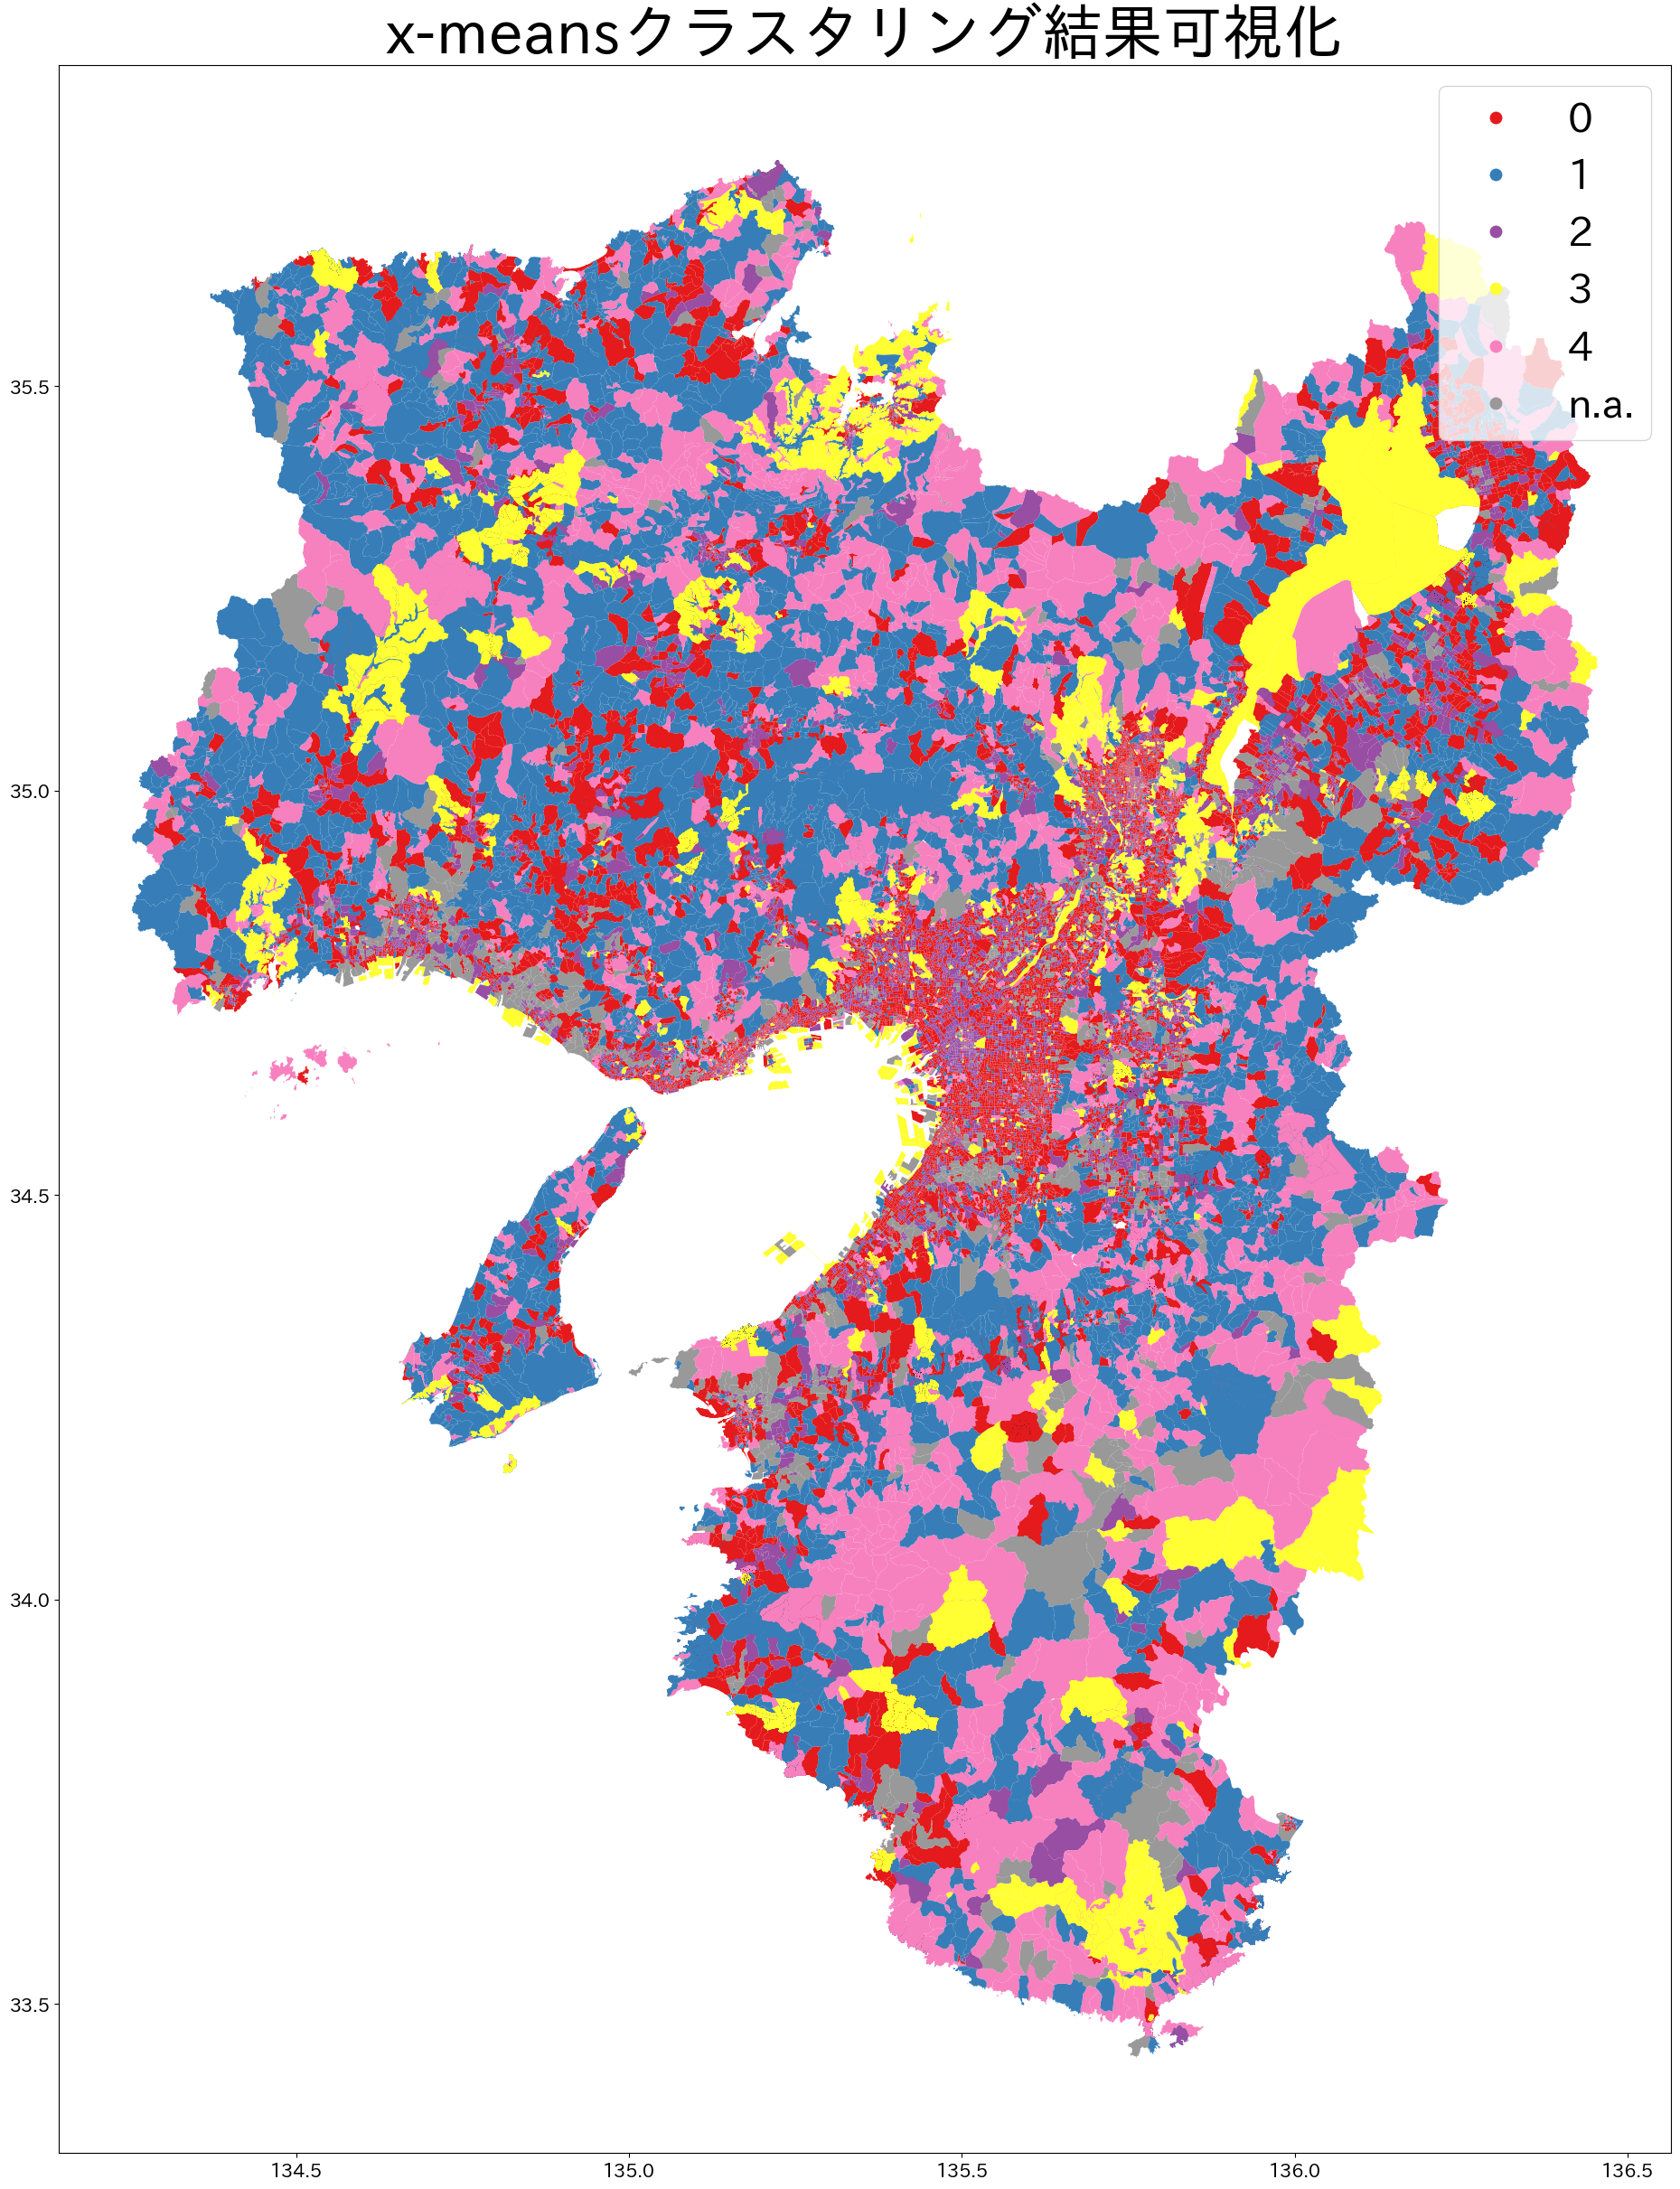

In [81]:
# クラスタリング結果で色分け（4区分）
plt.rc('legend', fontsize = 32)
df_mapping.plot(column = 'cluster',
        legend = True,
        figsize = [30, 30],
        cmap = 'Set1')
plt.title("x-meansクラスタリング結果可視化", fontsize = 48)
plt.savefig(output_path + 'xmeans_cluster_mapping.jpg', dpi = 300)
plt.show()

### 各変数のクラスターごとの分布を確認

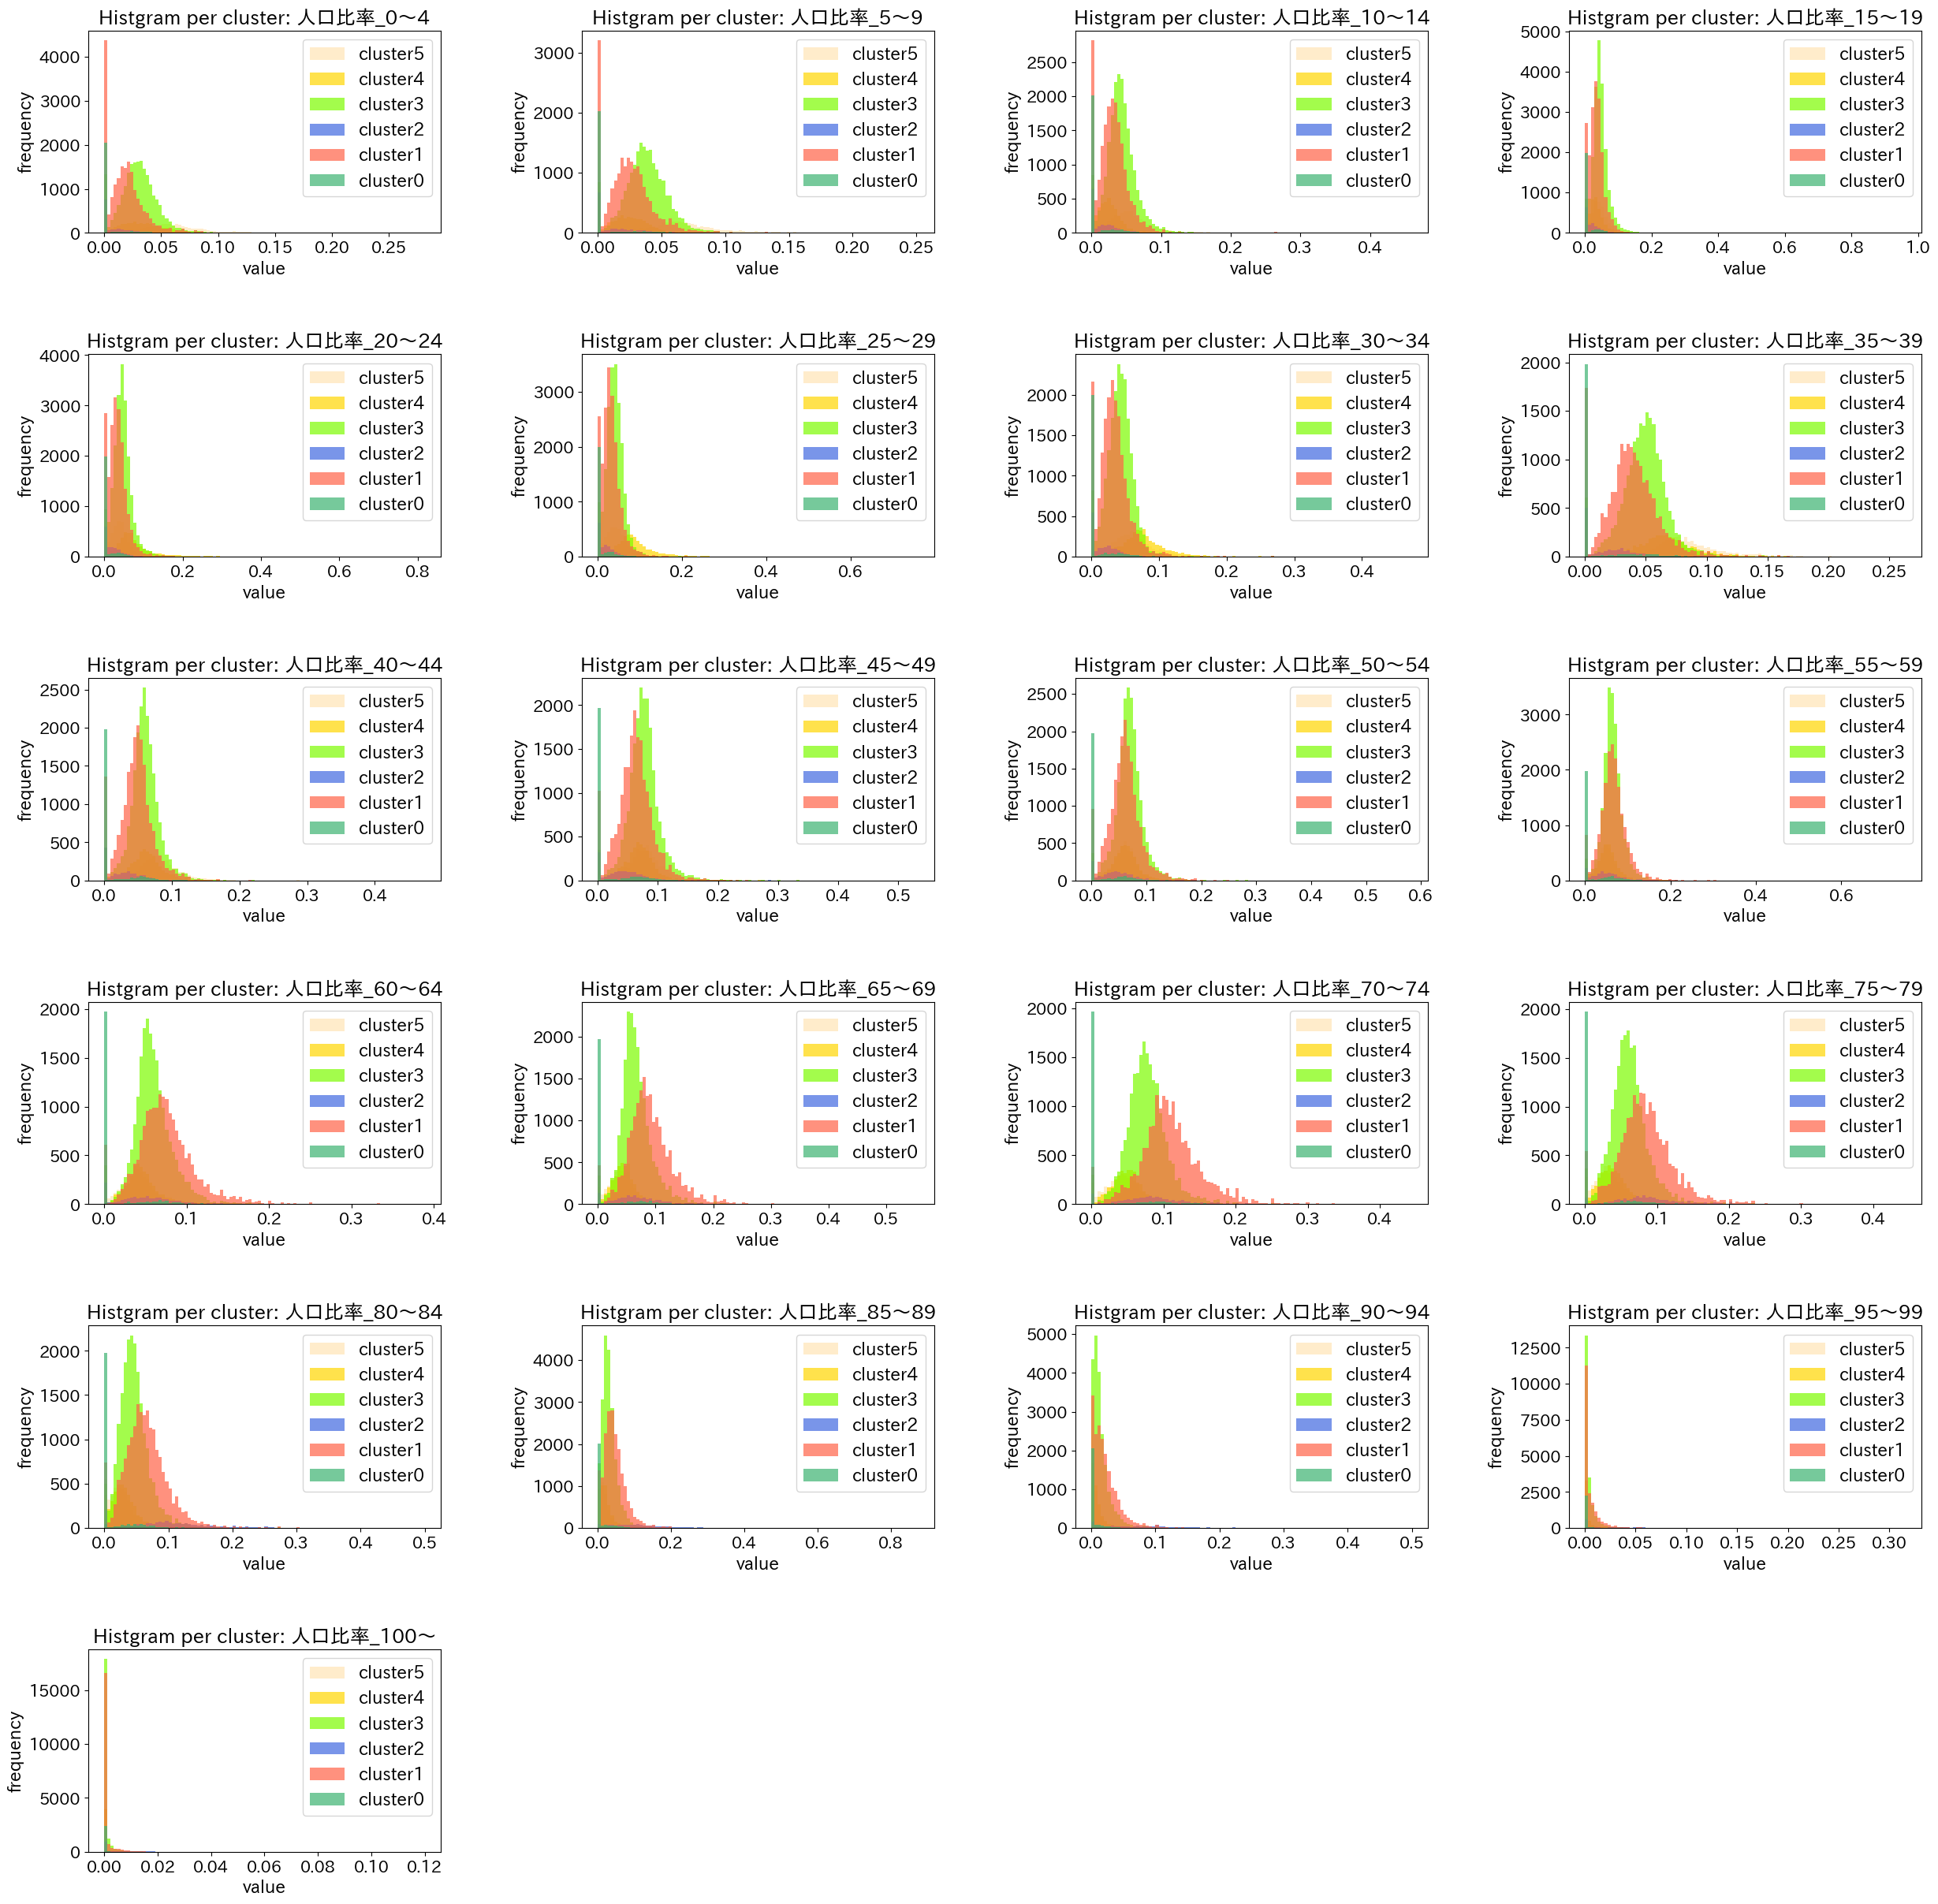

In [65]:
# 可視化用のデータリスト作成
plt.rcParams["font.size"] = 15
data_list = []
title_list = []
hist_columns = df_result.loc[:, '人口比率_0～4':'人口比率_100～'].columns
for col in hist_columns:
    # 積み上げ棒グラフでヒストグラムを描く
    x1 = df_result[df_result['cluster'] == 0][col]
    x2 = df_result[df_result['cluster'] == 1][col]
    x3 = df_result[df_result['cluster'] == 2][col]
    x4 = df_result[df_result['cluster'] == 3][col]
    x5 = df_result[df_result['cluster'] == 4][col]
    data_list.append([x1, x2, x3, x4, x5])
    
    title = 'Histgram per cluster: ' + col
    title_list.append(title)
    
# ここからがグラフ作成処理
# グラフのレイアウト（縦・横）
graph_row = 6
graph_col = 4

# グラフ作成
fig = plt.figure(figsize = (graph_col * 7.5, graph_row * 5))
ax_list = []
for j in range(graph_row):
    for i in range(graph_col):
        if (j * graph_col + i) < len(data_list):
            ax_list.append(fig.add_subplot(graph_row, graph_col, j * graph_col + i + 1))
            ax_list[j * graph_col + i].hist(data_list[j * graph_col + i],
                                            bins = 100,
                                            color = ['mediumseagreen', 'tomato', 'royalblue', 'lawngreen', 'moccasin'],
                                            label = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4'],
                                            histtype = 'stepfilled',
                                            alpha = 0.7)
            # 書式設定
            ax_list[j * graph_col + i].set_xlabel('value', fontsize = 16)
            ax_list[j * graph_col + i].set_ylabel('frequency', fontsize = 16)
            ax_list[j * graph_col + i].legend(loc ='best', fontsize = 16)
            ax_list[j * graph_col + i].set_title(title_list[j * graph_col + i], fontsize = 18)
            
            # 増加率の書式設定
#             if 9 <= (j * graph_col + i) <= 17:
#                 ax_list[j * graph_col + i].set_xlim(0, 10)
                    
# グラフ間の間隔指定
plt.subplots_adjust(wspace = 0.4, hspace = 0.6)
# 作成したグラフの保存
plt.savefig(output_path + 'xmeans_clustering_histgram.jpg', dpi = 300)
# グラフをコンソール上に表示
plt.show()

### 考察・解釈
- cluster0：2,462
    - 集計結果が得られていない or 他のクラスターに分類されなかった地域（値が0の地域を中心に分類されていた）
    - ほとんどが田舎地域
- cluster1：19,008
    - 高齢者（60代以上）の比率が高く、若年～中年（40代以下）の比率が低い地域
    - 都心から離れた郊外～田舎地域の大部分
- cluster2：1,575
    - 
- cluster3：20,554
    - 
- cluster4：4,270
    - 
- cluster5：4,329
    - 